In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import geopandas as gpd
from itertools import product

In [34]:
def load_and_preprocess_data(file_path):
    dataset = pd.read_csv(file_path)
    country_name_mapping = {
        "United States": "United States of America",
        "Bosnia and Herzegovina": "Bosnia and Herz.",
        "Central African Republic": "Central African Rep.",
        "Congo, Dem. Rep.": "Dem. Rep. Congo",
        "Cote d'Ivoire": "Côte d'Ivoire",
        "Dominican Republic": "Dominican Rep.",
        "Equatorial Guinea": "Eq. Guinea",
        "Czech Republic": "Czechia",
        "Kyrgyz Republic": "Kyrgyzstan",
        "Lao": "Laos",
        "Macedonia, FYR": "North Macedonia",
        "Slovak Republic": "Slovakia"
    }
    dataset['country'] = dataset['country'].replace(country_name_mapping)
    country_names = dataset['country']
    dataset_numeric = dataset.drop(columns=['country'])
    scaler = MinMaxScaler()
    dataset_scaled = scaler.fit_transform(dataset_numeric)
    return dataset, country_names, dataset_scaled

In [35]:
def euclidean_distance(x, w):
    return np.linalg.norm(x - w)

def manhattan_distance(x, w):
    return np.sum(np.abs(x - w))

In [36]:
def decay_learning_rate(init_learning_rate, t, max_iterations, decay_type='exp'):
    if decay_type == 'exp':
        return init_learning_rate * np.exp(-t / max_iterations)
    elif decay_type == 'linear':
        return init_learning_rate * (1 - t / max_iterations)
    else:
        raise ValueError("Invalid decay type. Choose 'exp' or 'linear'.")

def decay_sigma(init_sigma, t, max_iterations, decay_type='exp'):
    if decay_type == 'exp':
        return init_sigma * np.exp(-t / max_iterations)
    elif decay_type == 'linear':
        return init_sigma * (1 - t / max_iterations)
    else:
        raise ValueError("Invalid decay type. Choose 'exp' or 'linear'.")

In [37]:
def find_bmu(input_vector, weights, distance_func):
    min_dist = np.inf
    second_min_dist = np.inf
    bmu_idx = np.array([0, 0])
    second_bmu_idx = np.array([0, 0])
    
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            dist = distance_func(input_vector, weights[i, j])
            if dist < min_dist:
                second_min_dist = min_dist
                second_bmu_idx = bmu_idx
                min_dist = dist
                bmu_idx = np.array([i, j])
            elif dist < second_min_dist:
                second_min_dist = dist
                second_bmu_idx = np.array([i, j])

    topographical_error = np.linalg.norm(bmu_idx - second_bmu_idx) > 1
    
    return bmu_idx, min_dist, topographical_error

def neighborhood_function(bmu, grid_point, sigma):
    dist_to_bmu = np.linalg.norm(bmu - grid_point)
    return np.exp(-dist_to_bmu ** 2 / (2 * sigma ** 2))

In [38]:
def train_som(dataset_scaled, grid_size, init_learning_rate, init_sigma, n_iter, distance_func, decay_type):
    input_dim = dataset_scaled.shape[1]
    weights = np.random.random((grid_size[0], grid_size[1], input_dim))
    quantization_errors = []
    topographic_errors = []

    for t in tqdm(range(n_iter)):
        input_vector = dataset_scaled[np.random.randint(0, dataset_scaled.shape[0])]
        bmu_idx, min_cost, topographical_error = find_bmu(input_vector, weights, distance_func)
        quantization_errors.append(min_cost)
        topographic_errors.append(topographical_error)
        
        lr = decay_learning_rate(init_learning_rate, t, n_iter, decay_type)
        sigma = decay_sigma(init_sigma, t, n_iter, decay_type)
        
        for i in range(grid_size[0]):
            for j in range(grid_size[1]):
                grid_point = np.array([i, j])
                influence = neighborhood_function(bmu_idx, grid_point, sigma)
                weights[i, j] += influence * lr * (input_vector - weights[i, j])

    return weights, quantization_errors, topographic_errors

def plot_world_map(dataset, world):
    fig, ax = plt.subplots(figsize=(15, 10))
    world.plot(column='cluster', cmap='Set1', legend='cluster', ax=ax, edgecolor='black')
    world[world['cluster'].isna()].plot(ax=ax, color='black', edgecolor='black')
    ax.set_title('Country Clustering Using SOM', fontsize=16)
    plt.show()

def plot_u_matrix(u_matrix, grid_size):
    plt.figure(figsize=(8, 8))
    plt.imshow(u_matrix, cmap='coolwarm')
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            cluster_id = i * grid_size[1] + j
            plt.text(j, i, str(cluster_id + 1), ha='center', va='center', color='black')
    plt.colorbar(label='Distance')
    plt.title('U-Matrix with Cluster IDs', fontsize=16)
    plt.show()

def plot_error_trends(quantization_errors, topographic_errors, window_size=1000):
    quantization_errors_smooth = pd.Series(quantization_errors).rolling(window=window_size).mean()
    topographic_errors_smooth = pd.Series(topographic_errors).rolling(window=window_size).mean()

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    axes[0].plot(quantization_errors_smooth, color='blue', label='Smoothed Quantization Error')
    axes[0].set_title('Smoothed Quantization Error Over Time', fontsize=16)
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Error')
    axes[0].legend()

    axes[1].plot(topographic_errors_smooth, color='green', label='Smoothed Topographic Error')
    axes[1].set_title('Smoothed Topographic Error Over Time', fontsize=16)
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Error')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

def run_som_experiment(dataset_scaled, grid_sizes, learning_rates, sigmas, n_iters, distance_funcs, decay_types):
    results = []
    for params in product(grid_sizes, learning_rates, sigmas, n_iters, distance_funcs, decay_types):
        grid_size, lr, sigma, n_iter, dist_func, decay = params
        weights, quant_errors, topo_errors = train_som(dataset_scaled, grid_size, lr, sigma, n_iter, dist_func, decay)
        final_quant_error = np.mean(quant_errors[-1000:])
        final_topo_error = np.mean(topo_errors[-1000:])
        results.append({
            'grid_size': grid_size,
            'learning_rate': lr,
            'sigma': sigma,
            'n_iterations': n_iter,
            'distance_function': dist_func.__name__,
            'decay_type': decay,
            'final_quantization_error': final_quant_error,
            'final_topographic_error': final_topo_error
        })
    return pd.DataFrame(results)

In [39]:
dataset, country_names, dataset_scaled = load_and_preprocess_data('/kaggle/input/unsupervised-learning-on-country-data/Country-data.csv')

# Define parameter ranges for experimentation
grid_sizes = [(3, 3), (4, 4)]
learning_rates = [0.9, 0.5, 0.1]
sigmas = [1.5, 1, 0.5]
n_iters = [10000, 25000, 50000]
distance_funcs = [euclidean_distance, manhattan_distance]
decay_types = ['exp', 'linear']

# Run experiments
results_df = run_som_experiment(dataset_scaled, grid_sizes, learning_rates, sigmas, n_iters, distance_funcs, decay_types)

100%|██████████| 50000/50000 [00:25<00:00, 1959.96it/s]


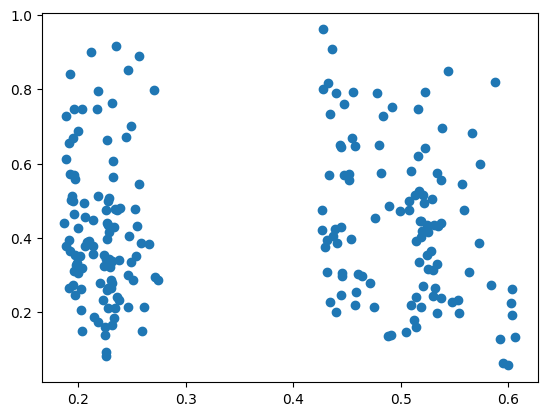

In [40]:
# Argumento que será mejor modelo si se está cerca tanto en quantization como en topographical.
plt.scatter(
    results_df['final_quantization_error'],
    results_df['final_topographic_error']
)

In [41]:
results_df['ranking'] = np.linalg.norm(results_df[['final_quantization_error', 'final_topographic_error']], axis=1)

    grid_size  learning_rate  sigma  n_iterations   distance_function  \
180    (4, 4)            0.1    1.5         10000  euclidean_distance   
96     (3, 3)            0.1    0.5         10000  euclidean_distance   
181    (4, 4)            0.1    1.5         10000  euclidean_distance   
188    (4, 4)            0.1    1.5         50000  euclidean_distance   
148    (4, 4)            0.5    1.5         25000  euclidean_distance   
..        ...            ...    ...           ...                 ...   
35     (3, 3)            0.9    0.5         50000  manhattan_distance   
70     (3, 3)            0.5    0.5         50000  manhattan_distance   
143    (4, 4)            0.9    0.5         50000  manhattan_distance   
26     (3, 3)            0.9    0.5         10000  manhattan_distance   
139    (4, 4)            0.9    0.5         25000  manhattan_distance   

    decay_type  final_quantization_error  final_topographic_error   ranking  
180        exp                  0.226007     

100%|██████████| 10000/10000 [00:04<00:00, 2084.55it/s]
/tmp/ipykernel_30/1854870040.py:26: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


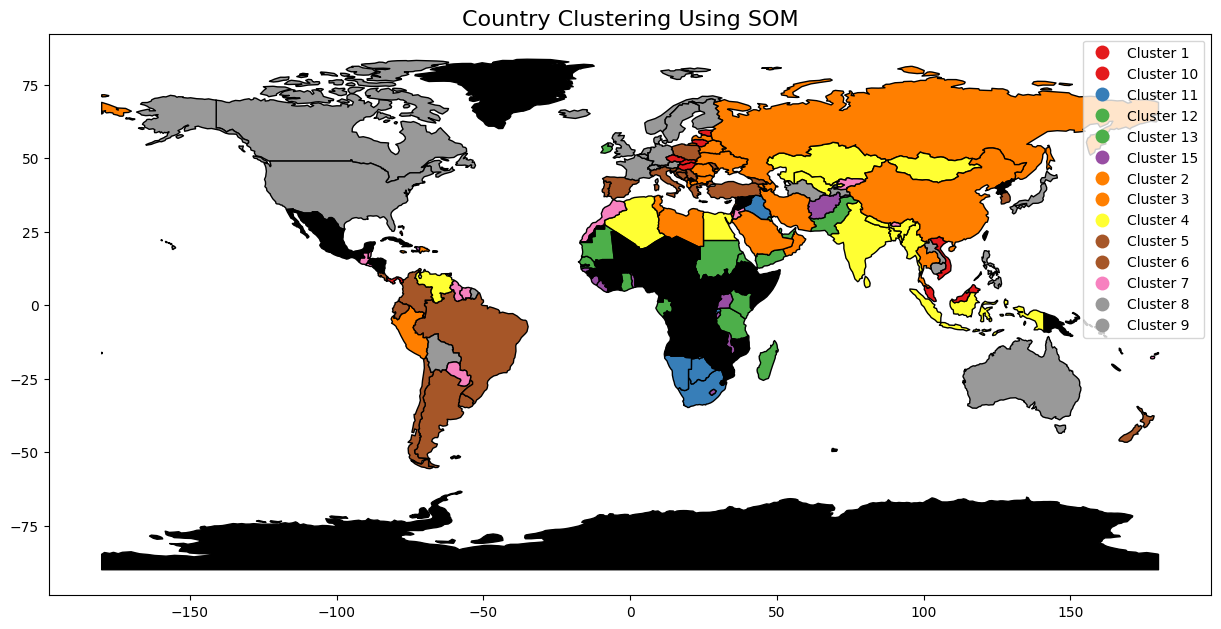

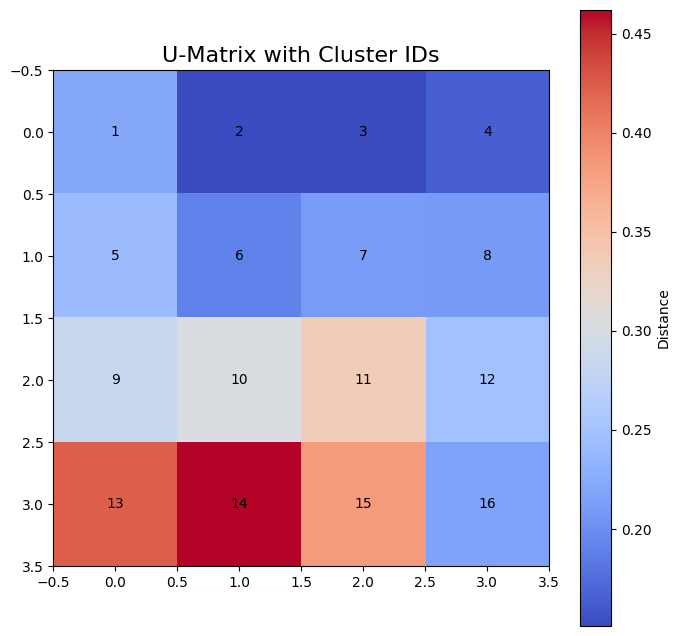

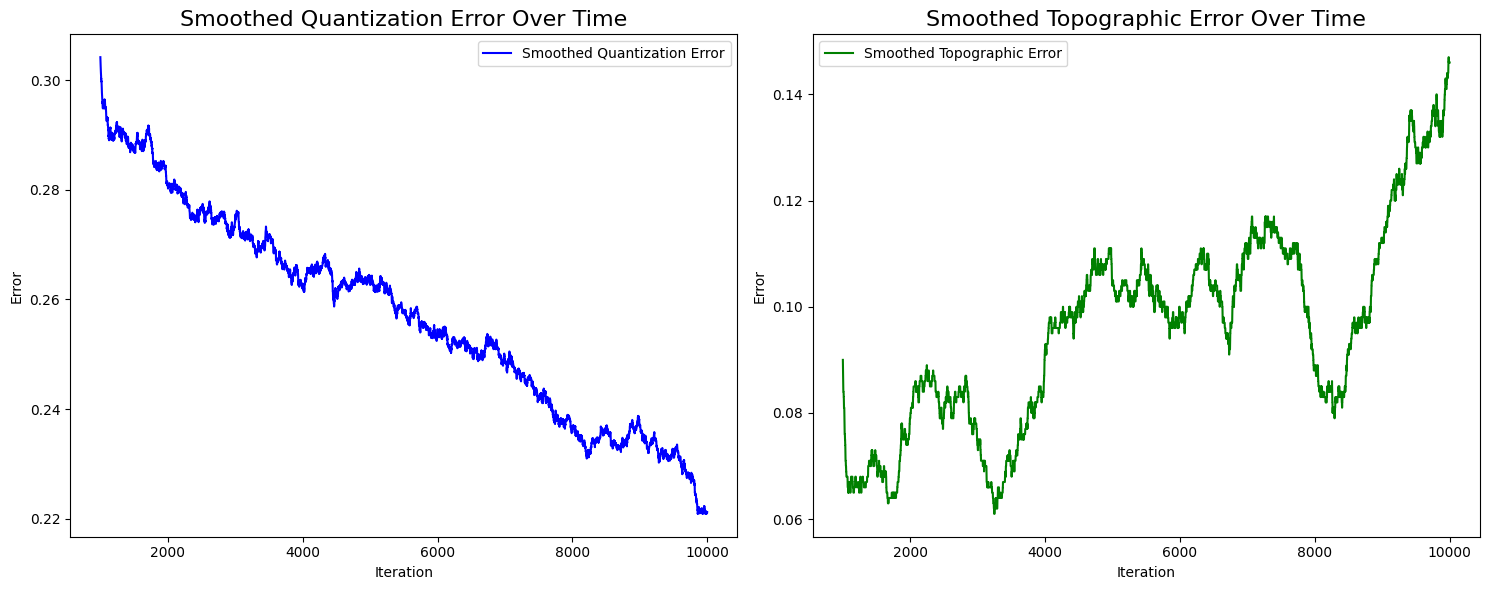

                                                      country
cluster                                                      
Cluster 1   [Bahrain, Czechia, Estonia, Hungary, Lithuania...
Cluster 10                                  [Bahamas, Israel]
Cluster 11  [Botswana, Iraq, Kiribati, Micronesia, Fed. St...
Cluster 12  [Comoros, Congo, Rep., Eritrea, Gabon, Gambia,...
Cluster 13  [Brunei, Ireland, Kuwait, Luxembourg, Qatar, S...
Cluster 15  [Afghanistan, Burundi, Guinea-Bissau, Haiti, L...
Cluster 2   [Albania, Antigua and Barbuda, Belarus, Bulgar...
Cluster 3   [Armenia, Azerbaijan, China, Dominican Rep., I...
Cluster 4   [Algeria, Bangladesh, Egypt, India, Indonesia,...
Cluster 5   [Cyprus, Greece, Italy, New Zealand, Portugal,...
Cluster 6   [Argentina, Barbados, Bosnia and Herz., Brazil...
Cluster 7   [Belize, Bhutan, Cape Verde, El Salvador, Fiji...
Cluster 8   [Bolivia, Cambodia, Laos, Philippines, Samoa, ...
Cluster 9   [Australia, Austria, Belgium, Canada, Denmark,...


In [42]:
# Display results
print(results_df.sort_values('ranking'))

# Select best configuration
best_config = results_df.loc[results_df['ranking'].idxmin()]

# Train SOM with best configuration
best_weights, best_quant_errors, best_topo_errors = train_som(
    dataset_scaled,
    best_config['grid_size'],
    best_config['learning_rate'],
    best_config['sigma'],
    best_config['n_iterations'],
    euclidean_distance if best_config['distance_function'] == 'euclidean_distance' else manhattan_distance,
    best_config['decay_type']
)

# Map data to best SOM
mapped_data = np.array([find_bmu(vec, best_weights, euclidean_distance)[0] for vec in dataset_scaled])
dataset['cluster'] = mapped_data[:, 0] * best_config['grid_size'][1] + mapped_data[:, 1]
dataset['cluster'] = dataset['cluster'].astype(int)
cluster_names = {i: f"Cluster {i+1}" for i in range(len(np.unique(dataset['cluster'])))}
dataset['cluster'] = dataset['cluster'].map(cluster_names)

# Visualizations
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(dataset[['country', 'cluster']], left_on='name', right_on='country', how='left')
plot_world_map(dataset, world)

u_matrix = np.zeros(best_config['grid_size'])
for i in range(best_config['grid_size'][0]):
    for j in range(best_config['grid_size'][1]):
        neighbors = []
        if i > 0: neighbors.append(best_weights[i - 1, j])
        if i < best_config['grid_size'][0] - 1: neighbors.append(best_weights[i + 1, j])
        if j > 0: neighbors.append(best_weights[i, j - 1])
        if j < best_config['grid_size'][1] - 1: neighbors.append(best_weights[i, j + 1])
        u_matrix[i, j] = np.mean([euclidean_distance(best_weights[i, j], neighbor) for neighbor in neighbors])

plot_u_matrix(u_matrix, best_config['grid_size'])
plot_error_trends(best_quant_errors, best_topo_errors)

print(dataset.groupby('cluster').agg({'country':'unique'}))

En esta actividad se entrenó un modelo Self-Organized Map. Ya que una de las aplicaciones de este tipo de modelos es la identificación de agrupamientos significativos, decidí tomar un dataset en el que se busca hacer agrupaciones de los países basado en variables de desarrollo económico, social, salud, entre otros. Esta fue la primera modificación, cambiando los datos con los que se trabajó. Para esta actividad, a diferencia del modelo LVQ, decidí implementar una búsqueda de hiperparámetros para decidir cuales son los mejores para la agrupacion. Los errores de cuantización tanto como los errores topográficos son relevantes para este ejemplo, por lo que se decidió ordenarlos por la norma L2 de estas dos variables y tomar la menor como el mejor modelo. También, decidí agregar unas gráficas para poder observar como se ven estas agrupaciones desde un mapa. También quise visualizar las distancias entre BMUs. Basandome en la actividad original, identifiqué que estoy buscando parametros que me permitan establecer diferencias claras entre agrupaciones, pero que la diferencia entre agrupaciones sea "natural". Se puede observar que de la cuantización para el mejor caso disminuye gradualmente, y bien si su error topográfico aumenta, es mínimo e incluso es el mejor resultado de toda la búsqueda de hiperparámetros. En esta busqueda, aprendí que para lograr este tipo de comportamiento el valor de sigma y el valor de la tasa de aprnedizaje son de los parametros con mayor peso en el impacto de como se clusterizan los datos. 